In [22]:
#######################Prophet model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
import pymysql
from datetime import datetime, timedelta
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

dbCon = pymysql.connect('hostname', 'username', 'password', 'database',
                       charset ='utf8', autocommit=True,
                       cursorclass=pymysql.cursors.DictCursor)

#x1: 변동비
x1='''SELECT  cc_costbill1.version_id AS ds, cc_costbill1.ic_dlvc+ cc_costbill1.ic_ohdvc AS y
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id'''#직접, 노무비,

#x2:고정비
x2='''SELECT cc_costbill1.ic_dlfc+cc_costbill1.ic_idlc
+cc_costbill1.ic_ohdfd+cc_costbill1.ic_ohdfe +cc_costbill1.ic_idohc AS x1,
cc_costbill1.version_id as date
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id''' #가만히있어도 돈dl 나가는 고정비

#y: 생산액
y='''SELECT cc_costbill1.proamt_unit*cc_costbill1.proq AS y, cc_costbill1.version_id AS ds
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id'''

y1='''SELECT cc_costbill.proamt_unit*cc_costbill.proq AS y, cc_costbill.periodym_cd*100 +1  AS ds
FROM cc_costbill;'''

curs = dbCon.cursor()
curs.execute(y1)
result =curs.fetchall()

df = pd.DataFrame(result)
df1=pd.DataFrame(result)
#int -> datetime
df['ds'] = df['ds'].astype(str)
df['ds'] = pd.to_datetime(df['ds'])
df = df.groupby(['ds'], as_index=False)['y'].agg('sum')
#covid19 트렌드 설정 (special events)
covid = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))

#Build model / 모델 만들기
model= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.95,
    holidays=holidays
)

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


            ds          yhat    yhat_lower    yhat_upper
0   2000-01-01  4.665257e+08  4.604516e+08  4.730715e+08
1   2000-02-01  4.670462e+08  4.610223e+08  4.735014e+08
2   2000-03-01  4.608478e+08  4.544928e+08  4.671463e+08
3   2000-04-01  4.597136e+08  4.529940e+08  4.661844e+08
4   2000-05-01  4.566089e+08  4.500920e+08  4.624959e+08
..         ...           ...           ...           ...
247 2020-08-01  4.500569e+08  4.434387e+08  4.562116e+08
248 2020-09-01  4.470725e+08  4.408652e+08  4.530917e+08
249 2020-10-01  4.490168e+08  4.425117e+08  4.552250e+08
250 2020-11-01  4.475007e+08  4.409438e+08  4.538810e+08
251 2020-12-01  4.469631e+08  4.405859e+08  4.529325e+08

[252 rows x 4 columns]


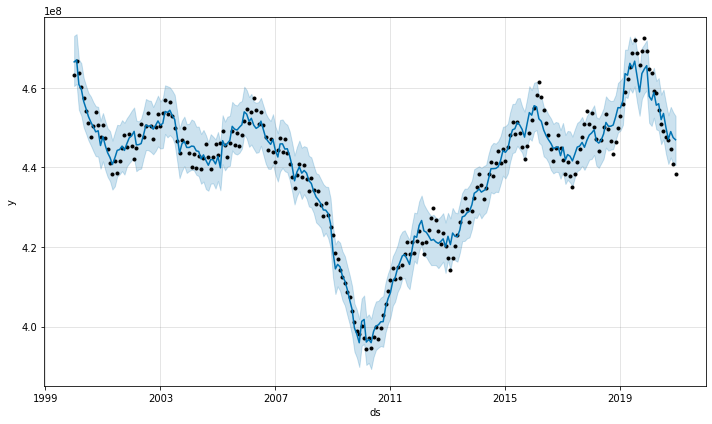

MAE: 12515748.756
MSE: 196497073686104.281
RMSE: 14017741.390
RMSLE: 0.031


In [23]:
#Add monthly pattern because data is month based data / 월주기 패턴 추가
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model.fit(df)
forecast = model.predict(df)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
model.plot(forecast)
plt.show()

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
mae = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(y_true, y_pred))

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


            ds          yhat    yhat_lower    yhat_upper
0   2000-01-01  4.665257e+08  4.605012e+08  4.725924e+08
1   2000-02-01  4.670462e+08  4.606062e+08  4.735359e+08
2   2000-03-01  4.608478e+08  4.542986e+08  4.667858e+08
3   2000-04-01  4.597136e+08  4.533911e+08  4.656814e+08
4   2000-05-01  4.566089e+08  4.502099e+08  4.630160e+08
..         ...           ...           ...           ...
259 2021-08-01  4.630996e+08  4.522073e+08  4.737649e+08
260 2021-09-01  4.610561e+08  4.477131e+08  4.732067e+08
261 2021-10-01  4.627920e+08  4.462313e+08  4.759576e+08
262 2021-11-01  4.615784e+08  4.438076e+08  4.779425e+08
263 2021-12-01  4.658610e+08  4.462421e+08  4.836761e+08

[264 rows x 4 columns]


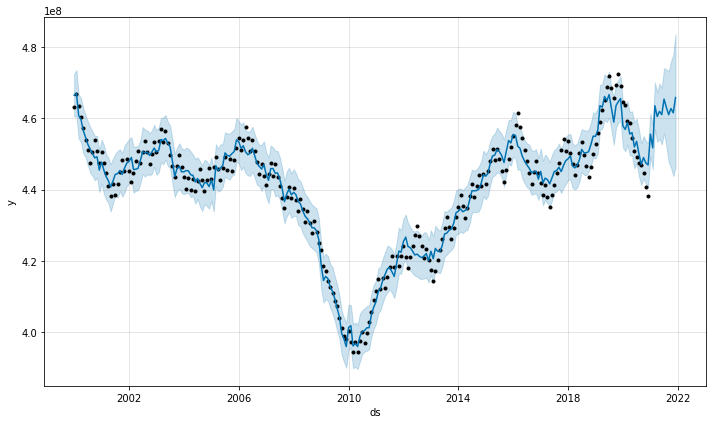

In [25]:
#With trained data(2000-01~2020-12)-> predict 2021-01~2021-12 
future = list()
for i in range(1, 13):
	date = '2021-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
# print(future)
future['ds']= pd.to_datetime(future['ds'])
forecast1= pd.concat((forecast, future))

# use the model to make a forecast
forecast1 = model.predict(forecast1)
# summarize the forecast
print(forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
model.plot(forecast1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


MAE: 12515748.756
MSE: 196497073686104.281
RMSE: 14017741.390
RMSLE: 0.031
            ds          y
0   2000-01-01  463224300
1   2000-02-01  466847310
2   2000-03-01  463611229
3   2000-04-01  460333062
4   2000-05-01  457442406
..         ...        ...
235 2019-08-01  468680579
236 2019-09-01  465722414
237 2019-10-01  469336219
238 2019-11-01  472552018
239 2019-12-01  469237857

[240 rows x 2 columns]


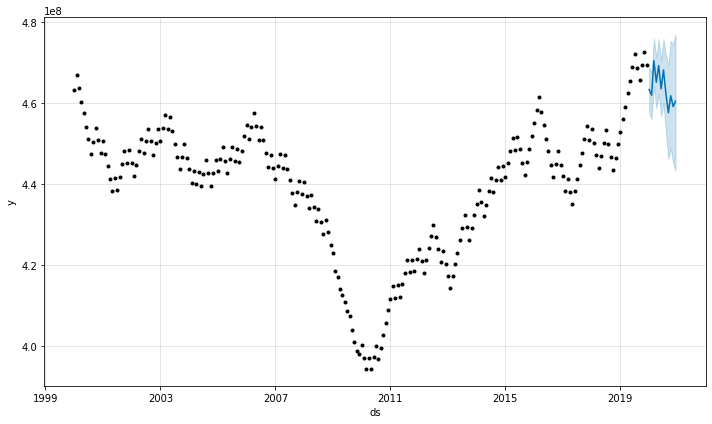

In [26]:
import numpy as np
#Train: 2000~2017,  Test: 2018~2020
# train = df.drop(df.index[-60:])
# y_true = df['y'][-60:].values
#Train: 2000~2019,  Test: 2020
train = df.drop(df.index[-12:])
y_true = df['y'][-12:].values
#covid19 트렌드 설정 (special events)
covid = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#Economy inflation
inflation = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
holidays = pd. concat((covid, inflation))
#월주기 패턴 추가
# 모델 생성 후 학습
model1 = Prophet(# trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
    interval_width = 0.95,
    holidays=holidays)

model1.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

model1.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = list()
# for i in range(1, 13):
#     last_1year.append(['2016-%02d' % i])
# for i in range(1, 13):
#     last_1year.append(['2017-%02d' % i])
# for i in range(1, 13):
#     last_1year.append(['2018-%02d' % i])
# for i in range(1, 13):
#     last_1year.append(['2019-%02d' % i])
for i in range(1, 13):
    last_1year.append(['2020-%02d' % i])        
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = model1.predict(last_1year)
y_pred = forecast['yhat'].values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
mae = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(y_true, y_pred))

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)


print(train)
model1.plot(forecast)
plt.show()

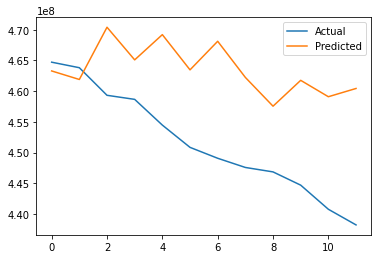

In [27]:
#3년 예측치 결과
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')

plt.legend()
plt.show()

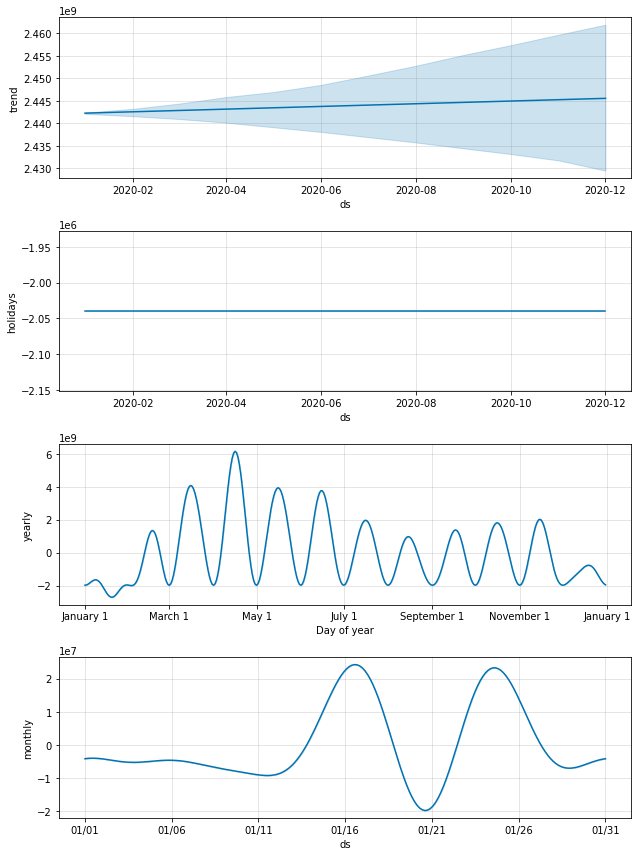

In [28]:
fig2 = model1.plot_components(forecast)
